# Finding True Barcodes
## Introduction
Our objective is to find which barcodes are genuine out of a list of many apparent barcodes. We begin by exploring the data to understand how the frequencies of barcodes are distributed. Next we justify how an estimation of the number of barcodes can be implemented if this number is unknown, or to confirm our results. We then implement an error correction which consolidates barcodes that are likely errors. Finally, we consider multiple optimizations and their trade-offs.

## Initial exploration
Initially, we can investigate the distribution of explicitly unique barcodes ignoring potential errors in sequencing and transcription. This plot shows the grouped counts on a log scale for all unique barcodes sorted by frequency. We can see that the distribution is heavily skewed right. 

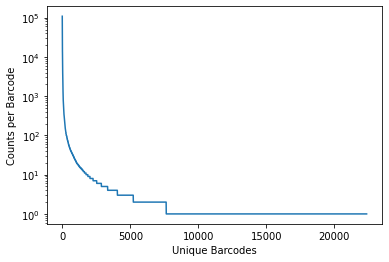

In [1]:
from collections import Counter

import matplotlib.pyplot as plt

ANCHOR = "GTACTGCGGCCGCTACCTA"
explicit_barcodes_counter = Counter()
explicit_barcodes_list = []


def group_barcodes(input_file):
    line_number = 0
    anchor_count = 0
    with open(input_file, "r") as file:
        for line in file:
            line_number += 1
            if (line_number + 2) % 4 == 0:
                anchor_index = line.find(ANCHOR, 30)
                if anchor_index != -1:
                    anchor_count += 1
                    barcode = line[anchor_index - 30 : anchor_index]
                    explicit_barcodes_counter[barcode] += 1

    for _, count in sorted(
        explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
    ):
        explicit_barcodes_list.append(count)


group_barcodes("./data_1M.fastq")
plt.plot(explicit_barcodes_list)
plt.ylabel("Counts per Barcode")
plt.xlabel("Unique Barcodes")
plt.semilogy()
plt.show()

Some reads have errors in the anchor sequence. Are we losing a significant amount of data by ignoring reads that do not have explicitly correct anchor sequences?

In [2]:
anchor_count = 0
with open("./data_1M.fastq") as f:
    for line_number, line in enumerate(f):
        if (line_number + 3) % 4 == 0:
            anchor_index = line.find("GTACTGCGGCCGCTACCTA", 30)
            if anchor_index != -1:
                anchor_count += 1
print(anchor_count)

948585


We can see that nearly 95% of reads are accounted for by only analyzing the explicitly correct anchor sequences.

## Estimate number of true barcodes

In some cases, an estimation of the number of true barcodes is useful. It could be used when the number of true barcodes in unknown. Alternatively, when we know the number of true barcodes, it can be used as evidence that our selection of true barcodes is accurate. In order to estimate the number of true barcodes, we can reason that, while some true barcodes have relatively few counts, they will have higher frequencies than most of the apparent barcodes. Because of this, a drop-off in quantity is expected to occur after the count of true barcodes. This drop-off can be shown in the following graph of the cumulative number of reads for each unique barcode, ordered by decreasing frequency.

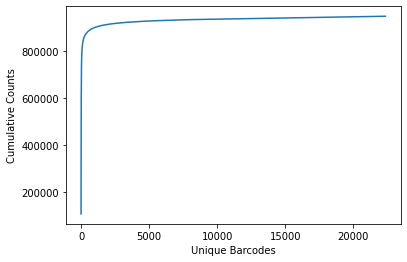

In [3]:
ydata = []
cumulative_counts = 0
for _, count in sorted(
    explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
):
    cumulative_counts += count
    ydata.append(cumulative_counts)

xdata = [*range(1, len(ydata) + 1)]
plt.plot(xdata, ydata)
plt.ylabel("Cumulative Counts")
plt.xlabel("Unique Barcodes")
plt.show()

 The drop-off after the true barcodes is visible in the graph in the form of a "knee" where the curve changes suddenly. When the number of true barcodes is unknown, we can use this point to estimate it. 

We can locate the knee point by finding the point on the cumulative curve with the maximum perpendicular distance from the linear interpolation between the first and last points on the plot. This point is analogous to the point on the curve with the maximum vertical height from the line. This maximum height is shown with the dashed orange line. 

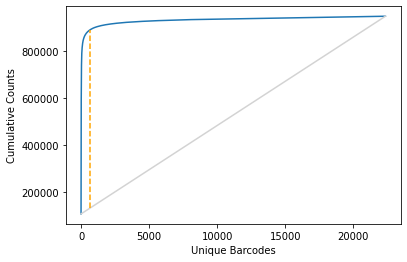

Estimated number of barcodes: 675


In [4]:
max_height_from_interpolation = 0
max_index = 0
for i in range(len(ydata)):
    height_from_interpolation = ydata[i] - (
        ((ydata[-1] - ydata[0]) / len(ydata)) * i + ydata[0]
    )
    if height_from_interpolation > max_height_from_interpolation:
        max_index = i
        max_height_from_interpolation = height_from_interpolation

plt.plot(xdata, ydata)
plt.ylabel("Cumulative Counts")
plt.xlabel("Unique Barcodes")
plt.plot([xdata[0], xdata[-1]], [ydata[0], ydata[-1]], c="lightgray")
# Draw vertical line from the interpolated gray line to the knee point
plt.plot(
    [max_index, max_index],
    [(((ydata[-1] - ydata[0]) / len(ydata)) * max_index + ydata[0]), ydata[max_index]],
    c="orange",
    ls="--",
)
plt.show()
print(f"Estimated number of barcodes: {max_index}")

## Error correction 
When the number of cells being sequenced is known and *errors are not being corrected*, generating a list of true barcodes is trivial. The most frequently occurring barcodes are the most likely to be true barcodes. This is because it is unlikely for multiple random errors to generate many identical false barcodes. We can use the number of cells sequenced to determine the threshold for true barcodes by selecting the barcodes with the highest frequency. When errors are attempted to be corrected, the answer is less straightforward.

Because errors are possible in sequencing and transcription, it is sometimes helpful to group together barcodes that have one (or more) incorrect base pairs. This allows for correction of some errors, but comes at the cost of introducing false positives into the results. It is possible for distinct barcodes to naturally have very similar base pair sequences, especially when the number of cells being sequenced is high. 

The function `group_by_hamming_distance()` groups less common barcodes with more common barcodes if they have a Hamming distance less than or equal to `max_hamming_distance`, which is set as 1 in the function arguments. `find_hamming_neighbor()` and `is_hamming_neighbor()` are used to determine if a Hamming neighbor exists within the already seen barcodes in the `grouped_barcodes` dictionary. 

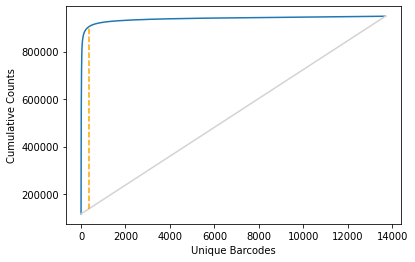

Estimated number of barcodes: 369


In [5]:
def group_by_hamming_distance(explicit_barcodes_counter, max_hamming_distance):
    grouped_barcodes = {}
    for explicit_barcode, explicit_count in sorted(
        explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
    ):
        if not grouped_barcodes:
            grouped_barcodes[explicit_barcode] = explicit_count
            continue
        neighbor = find_hamming_neighbor(
            explicit_barcode, grouped_barcodes, max_hamming_distance
        )
        # If there exists a neighbor barcode in grouped_barcodes
        if neighbor is not None:
            grouped_barcodes[neighbor] += explicit_count
        else:
            grouped_barcodes[explicit_barcode] = explicit_count
    return grouped_barcodes


def find_hamming_neighbor(explicit_barcode, grouped_barcodes, max_hamming_distance):
    for grouped_barcode in grouped_barcodes.keys():
        if is_hamming_neighbor(explicit_barcode, grouped_barcode, max_hamming_distance):
            return grouped_barcode
    return None


def is_hamming_neighbor(string1, string2, max_hamming_distance):
    assert len(string1) == len(
        string2
    ), "Error: barcode sequences must be the same length"
    length = len(string1)
    distance = 0
    i = 0
    while i < length and distance <= max_hamming_distance:
        if string1[i] != string2[i]:
            distance += 1
        i += 1
    if distance <= max_hamming_distance:
        return True
    return False


grouped_barcodes = group_by_hamming_distance(explicit_barcodes_counter, 1)

ydata = []
cumulative_counts = 0
for _, count in sorted(grouped_barcodes.items(), key=lambda x: x[1], reverse=True):
    cumulative_counts += count
    ydata.append(cumulative_counts)
max_height_from_interpolation = 0
max_index = 0
for i in range(len(ydata)):
    height_from_interpolation = ydata[i] - (
        ((ydata[-1] - ydata[0]) / len(ydata)) * i + ydata[0]
    )
    if height_from_interpolation > max_height_from_interpolation:
        max_index = i
        max_height_from_interpolation = height_from_interpolation

xdata = [*range(1, len(ydata) + 1)]
plt.plot(xdata, ydata)
plt.ylabel("Cumulative Counts")
plt.xlabel("Unique Barcodes")
plt.plot([xdata[0], xdata[-1]], [ydata[0], ydata[-1]], c="lightgray")
plt.plot(
    [max_index, max_index],
    [(((ydata[-1] - ydata[0]) / len(ydata)) * max_index + ydata[0]), ydata[max_index]],
    c="orange",
    ls="--",
)
plt.show()
print(f"Estimated number of barcodes: {max_index}")

Applying this correction results in an estimate of 369 barcodes. Knowing the number of cells sequenced for this data would allow the efficacy of this error correction method to be tested. Going forward, we will use this estimate for the number of cells sequenced. 

This error correction method groups by Hamming distance indiscriminately, meaning it assumes all substitution errors are equally likely. In the Appendix, we explore why this assumption is incorrect. 

## Optimizing runtime by considering only the most common barcodes

The current runtime of this Hamming neighbor error correction is impractical. At worst it is $O((N^2)(H))$ (where N is the number of unique barcodes and H is the length of the barcode). The quadratic runtime is due to comparing every barcode to every other barcode. 

It seems unlikely for the uncommon barcodes to change the end result of true barcodes by much, given the skewed distribution. Here we modify the above code to only consider the most frequent barcodes. We do this with the variable `proportion` which represents the number of barcode groups to create before stopping, proportional to the cell count.

Let's generate two lists of true barcodes grouped by Hamming-1 neighbors. One by comparing the entire dataset, and another by comparing only the minimal number of most frequent barcodes necessary to make 369 unique groups. We can then see how the results differ.

In [6]:
def group_top_barcodes_by_hamming_distance(
    barcode_counter, cell_count, max_hamming_distance, proportion
):
    grouped_top_barcodes = {}
    barcode_groups = 0
    max_number_of_barcode_groups = cell_count * proportion
    for explicit_barcode, explicit_count in sorted(
        barcode_counter.items(), key=lambda x: x[1], reverse=True
    ):
        # stop grouping and return once we reach this number of unique true barcode
        if barcode_groups > max_number_of_barcode_groups:
            return grouped_top_barcodes

        if not grouped_top_barcodes:
            grouped_top_barcodes[explicit_barcode] = explicit_count
            continue
        neighbor = find_hamming_neighbor(
            explicit_barcode, grouped_top_barcodes, max_hamming_distance
        )
        if neighbor is not None:
            grouped_top_barcodes[neighbor] += explicit_count
        else:
            grouped_top_barcodes[explicit_barcode] = explicit_count
            # Increment each time a unique barcode is added to grouped_top_barcodes
            barcode_groups += 1
    return grouped_top_barcodes


def get_true_barcodes(barcode_counter, cell_count):
    true_barcodes = []
    for explicit_barcode, _ in sorted(
        barcode_counter.items(), key=lambda x: x[1], reverse=True
    ):
        true_barcodes.append(explicit_barcode)
        if len(true_barcodes) == cell_count:
            break
    return true_barcodes


# Arguments
hamming_distance = 1
cell_count = 369
proportion = 1


# Get a list of true barcodes by analyzing the top max_number_of_barcode_groups
grouped_top_barcodes = group_top_barcodes_by_hamming_distance(
    explicit_barcodes_counter, cell_count, hamming_distance, proportion
)
true_barcodes_from_top = get_true_barcodes(grouped_top_barcodes, cell_count)

# Get a list of true barcodes after analyzing the entire dataset
grouped_all_barcodes = grouped_barcodes
true_barcodes_from_all = get_true_barcodes(grouped_all_barcodes, cell_count)


print(set(true_barcodes_from_top) - set(true_barcodes_from_all))

{'GCATGTTATTCGGTATAACAACCGACTACT', 'TGGGGGTTTGACAGGATTCCCCATGGTGTT', 'GTTGCACTTAACGCTCGGGCGAGGCCCTCT', 'GTCCGCGCGCCCGATGGACAAGAAGTGCTC', 'TATAGTCGGGAATAAGGACCTACAGCAGCT', 'ATGATCTTTATCTATTTAAGATGCAAGACT', 'GGGGTCATTTCCGCCGCGGAGTAGGTTTTC', 'CGGTAGTGCCCATCTTGCGCTGGACGAGCT'}



Massive improvements are demonstrated by only considering the most frequent barcodes due to the quadratic runtime. Using the estimated value of 369 for `cell_count`, the resulting list of barcodes from the abridged search is only 8 barcodes different than the overall exhaustive search result (98% in common). The advantage is that with such a small set of barcodes to compare, we can generate this list with 98% accuracy in a fraction of a second. This is an improvement in runtime by a factor of over 200 compared to analyzing the entire dataset. 

The `proportion` variable can be increased to consider a higher proportion of barcodes, effectively making the error correction more thorough. The default value of 1 will do the minimum number of comparisons necessary in order to return `cell_count` number of barcode groups. This means with a `proportion` of 1 and a `cell_count` of 369, we will stop as soon as we find 369 unique groups. A `proportion` of 2 would stop once 738 groups are found. Higher values will consider more barcodes, resulting in results that align more closely with the entire dataset, at the expense of runtime. 

The runtime complexity of this abridged search method is still $O((N^2)(H))$, where N is the number of barcodes compared. The advantage here is that N is *minimized* when `proportion` is 1, but the exact number will vary based on the dataset.  

Let's see at what positions the differences between the two analysis techniques occur. 

In [7]:
for position, barcode in enumerate(true_barcodes_from_top):
    if barcode not in true_barcodes_from_all:
        print(position)

356
359
361
363
365
366
367
368


Here we can see that the first continuous 357 results (96%) of the abridged search method exists in the results from the exhaustive search method. This confirms that the majority of the discrepancies (relative to the exhaustive search), are likely to occur near the threshold for true barcodes. 



## Appendix: Potential optimizations to runtime and logic
### Hamming distance correction optimizations

Here we explore the distribution of barcodes within 1 Hamming distance of one another, make observation on the distribution of presumed errors, and speculate on how this might be useful in error correction. 

First, let's try to find the 10 most common barcodes which are within a Hamming distance of 1 from another more common barcode.

In [8]:
def check_for_hamming_neighbors(max_hamming_dist=1):
    seen_barcodes = []
    i = 0
    for explicit_barcode, count in sorted(
        explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
    ):
        if not seen_barcodes:
            seen_barcodes.append(explicit_barcode)
            continue
        for seen_barcode in seen_barcodes:
            if i >= 10:  # Stop once count of unique groups exceedes this
                break
            if is_hamming_neighbor(explicit_barcode, seen_barcode, max_hamming_dist):
                i += 1
                print("seen: ", seen_barcode)
                print("new:  ", explicit_barcode, "\n")
        seen_barcodes.append(explicit_barcode)
    return 1


def is_hamming_neighbor(string1, string2, max_hamming_dist):
    assert len(string1) == len(string2)
    length = len(string1)
    distance = 0
    i = 0
    while i < length and distance <= max_hamming_dist:
        if string1[i] != string2[i]:
            distance += 1
        i += 1
    if distance <= max_hamming_dist:
        return True
    return None


first_neighbor = check_for_hamming_neighbors()

seen:  GGGGTCATATCCGCCGCGGAGTAGGATTTC
new:   GGGGTCATTTCCGCCGCGGAGTAGGATTTC 

seen:  CATAGTCTGCTTAAGCGCTATATTATTCCT
new:   CATAGTCTGCTTTAGCGCTATATTATTCCT 

seen:  TTGTAATTTTATACTACTGGTAGAGGTTCT
new:   TTGTAATTTTATTCTACTGGTAGAGGTTCT 

seen:  GGGGTCATATCCGCCGCGGAGTAGGATTTC
new:   GGGGTCTTATCCGCCGCGGAGTAGGATTTC 

seen:  CATAGTCTGCTTAAGCGCTATATTATTCCT
new:   CATAGTCTGCTTATGCGCTATATTATTCCT 

seen:  GGGGTCATATCCGCCGCGGAGTAGGATTTC
new:   GGGGTCATATCCGCCGCGGAGTTGGATTTC 

seen:  CGAACTCGGGGTGGTCCTTGGGAACTAACC
new:   CGACCTCGGGGTGGTCCTTGGGAACTAACC 

seen:  TTGTAATTTTATACTACTGGTAGAGGTTCT
new:   TTGTAATTTTATACTTCTGGTAGAGGTTCT 

seen:  CATAGTCTGCTTAAGCGCTATATTATTCCT
new:   CATTGTCTGCTTAAGCGCTATATTATTCCT 

seen:  TTGTAATTTTATACTACTGGTAGAGGTTCT
new:   TTGTATTTTTATACTACTGGTAGAGGTTCT 



Let's refer the more frequent barcodes (ones that have already been seen) as the true barcodes, and the barcodes with one different base pair (new) as errors in reading the true barcodes. Curiously, of the first 10 errors found in the dataset, almost every change is an A being misread as a T. Also, in all of the above cases, when the initial A is being misread as a T, the base pair is adjacent to a T. It is unclear why adjacent base pairs might be affecting each other.

Perhaps we can leverage the pattern of As turning into Ts to resolve errors that have 1 or more different base pairs. For example, these three barcodes are all output from the above code on the `data_100K.fastq` dataset. Each is only 1 base pair away from the previous.

```
GGGGTCATATCCGCCGCGGAGTAGGATTTC
GGGGTCATTTCCGCCGCGGAGTAGGATTTC
GGGGTCTTTTCCGCCGCGGAGTAGGATTTC
```

The second and third barcode are the 39th and 67th most frequent unique barcodes, respectively. This is frequent enough for both to be considered to be a true barcodes by the previous methods. However, it is possible that these are both errors propagating from the same most common barcode. 

Next, let's investigate whether this pattern is present throughout the entire dataset. Of all barcodes within 1 base pair of a previously seen barcode, what are the frequencies of each exhibited substitution?

In [9]:
def get_error_freqs():
    """
    returns a Counter of each of the possible 1-Hamming substitutions and their frequencies
    """
    error_freq = Counter()
    seen_barcodes = []

    for explicit_barcode, count in sorted(
        explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
    ):
        if not seen_barcodes:
            seen_barcodes.append(explicit_barcode)
            continue

        for seen_barcode in seen_barcodes:
            """
            for loop checks every unique barcode against every seen barcode, including multiple error paths to same barcode
            """
            base_change = get_base_change(seen_barcode, explicit_barcode)
            if base_change is not None:
                error_freq[base_change[0], base_change[1]] += 1
        seen_barcodes.append(explicit_barcode)
    return error_freq


def get_base_change(string1, string2):
    """
    returns a tuple of the base that differs from string1 and string2 if the change is less than 1 Hamming distance: (base1, base2)
    """
    assert len(string1) == len(string2)
    length = len(string1)
    difference = None
    i = 0
    while i < length:
        if string1[i] != string2[i]:
            if difference is None:
                difference = (string1[i], string2[i])
            # If more than one difference is found between the strings, return None
            else:
                return None
        i += 1
    return difference


common_barcode_errors = get_error_freqs()

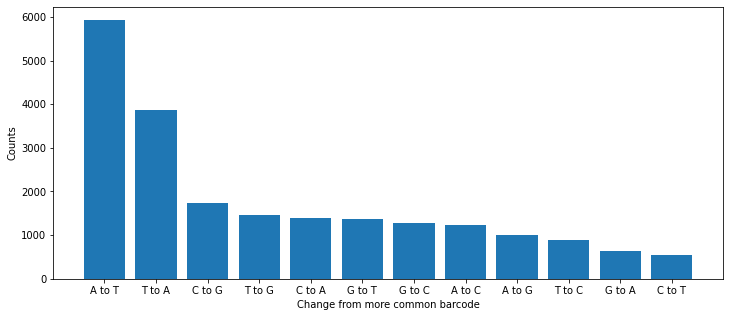

A to T error proportion: 0.2775957307368224
A to T or T to A error proportion: 0.4588989794963018


In [10]:
data = []
label = []
for k, v in sorted(common_barcode_errors.items(), key=lambda x: x[1], reverse=True):
    data.append(v)
    label.append(k[0] + " to " + k[1])
plt.figure(figsize=(12, 5))
plt.bar(label, data)
plt.xlabel("Change from more common barcode")
plt.ylabel("Counts")
plt.show()

print(f"A to T error proportion: {data[0] / sum(data)}")
print(f"A to T or T to A error proportion: {(data[0] + data[1]) / sum(data)}")

The distribution of barcodes with low Hamming distances to similar barcodes is definitely not random. If this was a random process, the bars in this plot would have similar height. The proportion of estimated errors of Hamming-1 neighbors by substituting an A as T is about one third. The proportion of estimated errors for A to T and T to A combined is nearly one half.

It is unclear what is causing this distribution, however, an error correction algorithm could be designed to show specific tolerance to this distribution of errors. For example, it is now more likely that the barcode `GGGGTCTTTT...` is simply an error of the very common barcode `GGGGTCATAT...`. 

### Using read quality in logic

There exist many reads where the quality of multiple base pairs is low. The following read has a correct anchor and a common barcode.
```
@VH00272:1:AAAJ3MHM5:1:2610:42260:32407 2:N:0:ATCACGATCG+CGACTCCTAC
GGGGGTCATATCCGCCGCGGAGTAGGATTTCGTACTGCGGCCGCTACCTAATTGCCGTCGTGAGGTACGACCACCGCTT
+
CCCCC-----CC-C;CCC-C-C-CCCCC;CC;CCCCCC;CCCCCCCCC;-CCC;;CCCC-CCCCCC;CC-CCCCCC-C-
```
If reads like this have such low quality, they probably don't add much confidence to our overall conclusions, despite matching other barcodes. Depending on how often these appear, an argument could be made for removing them from analysis. 

Conversely, we can also use the quality to increase the reliability of our data. For example, if a read has mostly high quality, but less quality for the one base pair that it differs from a true barcode, we can have greater confidence that it is an error from the sequencing process. 

### Parallelization using a graph of neighbors
The current method cannot be easily parallelized due to how barcode neighbors are grouped. Once a barcode is grouped with a more common barcode, it is removed from the set of barcodes being compared. 

Another solution would involve building a graph of barcodes where each edge represents a Hamming distance of 1 between two barcodes. The overall runtime complexity is similar, but because the graph is not changing, searching for neighbors of a defined Hamming distance could be parallelized. It also would allow for multiple error correction strategies to be tested without rebuilding the data structure each time. 

### Skipping low frequency barcodes

This is a similar (but much less useful) idea to considering only the most common barcodes. Instead, we can stop error-correction once we can prove the less common barcodes will not be able to influence the results. 

Looking at our first figure in this notebook, we can see that over half of the barcodes (>10,000) have a frequency of 1. Could these all be Hamming-1 neighbors of a single barcode? The most that all of these barcodes could possibly shift a single barcode is 90 counts. That is in the case that every possible Hamming-1 neighbor existed in this group of single frequency barcodes. This number comes from the fact that there are 30 base pairs and 3 possible directions for each substitution. In certain datasets, we could cut our our initial search size in half by omitting these barcodes. 

The idea for when we can stop considering barcodes is once all possible Hamming neighbors can no longer push a non-true barcode over the threshold for true barcodes (the threshold defined by the least frequent true barcode). This means we can stop considering other barcodes when `last_true_count - explicit_count * 90 > 0` evaluates to true, where `last_true_count` is the smallest cumulative count within the true barcodes and `explicit_count` is the cumulative count of the current barcode we are considering comparing with all other barcodes we have processed so far. 

In a large enough dataset, the smallest cumulative count within the true barcodes could be much larger than 90. In some cases, this optimization would apply to more than just the barcodes with counts of 1. Let's apply this method to the `data_1M.fastq` dataset and see what conclusions we can make.

In [11]:
def group_skip_low_freq(explicit_barcodes_counter, cell_count, max_hamming_distance):
    last_true_count = 0
    grouped_barcodes_skip_low = {}
    for explicit_barcode, explicit_count in sorted(
        explicit_barcodes_counter.items(), key=lambda x: x[1], reverse=True
    ):
        # Stop considering barcodes once they can no longer affect end result
        if last_true_count - explicit_count * 90 > 0:
            print(f"stopped processing once explicit_count reached {explicit_count}.")
            return grouped_barcodes_skip_low

        if not grouped_barcodes_skip_low:
            grouped_barcodes_skip_low[explicit_barcode] = explicit_count
            last_true_count = explicit_count
            continue

        neighbor = find_hamming_neighbor(
            explicit_barcode, grouped_barcodes_skip_low, max_hamming_distance
        )
        if neighbor is not None:
            grouped_barcodes_skip_low[neighbor] += explicit_count
            if len(grouped_barcodes_skip_low) < cell_count:
                last_true_count = min(
                    last_true_count, grouped_barcodes_skip_low[neighbor]
                )
        else:
            grouped_barcodes_skip_low[explicit_barcode] = explicit_count
            if len(grouped_barcodes_skip_low) < cell_count:
                last_true_count = min(
                    last_true_count, grouped_barcodes_skip_low[explicit_barcode]
                )

    return grouped_barcodes_skip_low


cell_count = 265
max_hamming_distance = 1

grouped_barcodes_skip_low = group_skip_low_freq(
    explicit_barcodes_counter, cell_count, max_hamming_distance
)

stopped processing once explicit_count reached 1.


In order for this optimization to apply to the dataset, the number of cells sequenced needs to be much lower (approximately 260) than the estimated number of 369 cells. This means that this optimization is situational, depending on the data and number of cells sequenced. Because it is extremely unlikely for all 90 exact Hamming neighbors to exist, this method could be made less conservative to make it more useful. 